In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
plt.style.use('ggplot')

## Временной ряд

Что делает данные времянных рядов особенными?

* наша выборка больше не является независимой;
* автокорелляция ошибок;
* сезонные колебания;
* если наблюдается тенденция, развивающаяся с течением времени, то говорят что в данных наблюдается тренд.

In [3]:
data = pd.read_csv('AirPassengers.csv')
print data.head()

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121


Одним из основополагющих понятий в анализе временных рядов является стационарность. 

Ее принято рассматривать в 2 смыслах:

- строгая стационарность: сдвиг во времени не меняет ни одну из функций распределения;
- слабая стационарность: среднее и дисперсия постоянны и не зависят от времени, а функция автокорреляции зависит только от сдвига времени.

Функция автокорреляции:

$$ r_{\tau} = \frac{\sum_{t=1}^{T-\tau} (y_t-\bar{y})(y_{t+\tau}-\bar{y}) }{\sum_{t=1}^T (y_t-\bar{y})^2} $$

Белый шум

Белый шум - процесс с нулевым мат ожиданием и постоянной дисперсией.

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
dateparse('1962-01')
data = pd.read_csv('AirPassengers.csv', parse_dates=True, index_col='Month',date_parser=dateparse)
print data.head()
data= data.astype("float64")

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [5]:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
Name: #Passengers, dtype: float64

Индексирование данных временных рядов в pandas сделано достаточно удобно:

In [6]:
ts['1949-01-01']

112.0

In [7]:
from datetime import datetime
ts[datetime(1949,1,1)]

112.0

In [8]:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: #Passengers, dtype: float64

In [9]:
ts['1949']

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
1949-11-01    104.0
1949-12-01    118.0
Name: #Passengers, dtype: float64

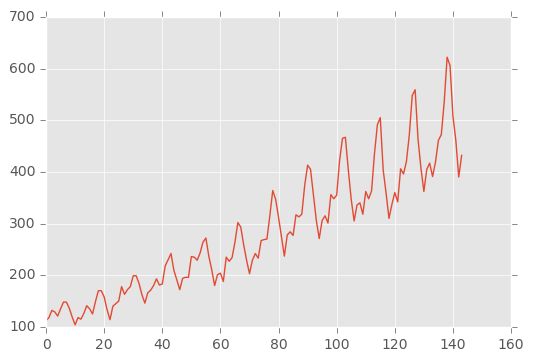

In [10]:
plt.plot(ts)

Может ли приведенный процесс считаться стационарным? Формальный способ ответа мы рассмотрим чуть позже, воспользовавшись тестом Дики-Фуллера.

Частная автокорреляционная функция демонстрирует корреляцию между двумя временными лагами за вычетом влияния всех внутренних значений автокорреляции. В частной автокорреляционной функции устраняется зависимость между наблюдениями внутри лага (промежуточными наблюдениями). Частная автокорреляция на данном лаге аналогична обычной автокорреляции, за исключением того, что при вычислении из неё исключается влияние автокорреляций с меньшими лагами.

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


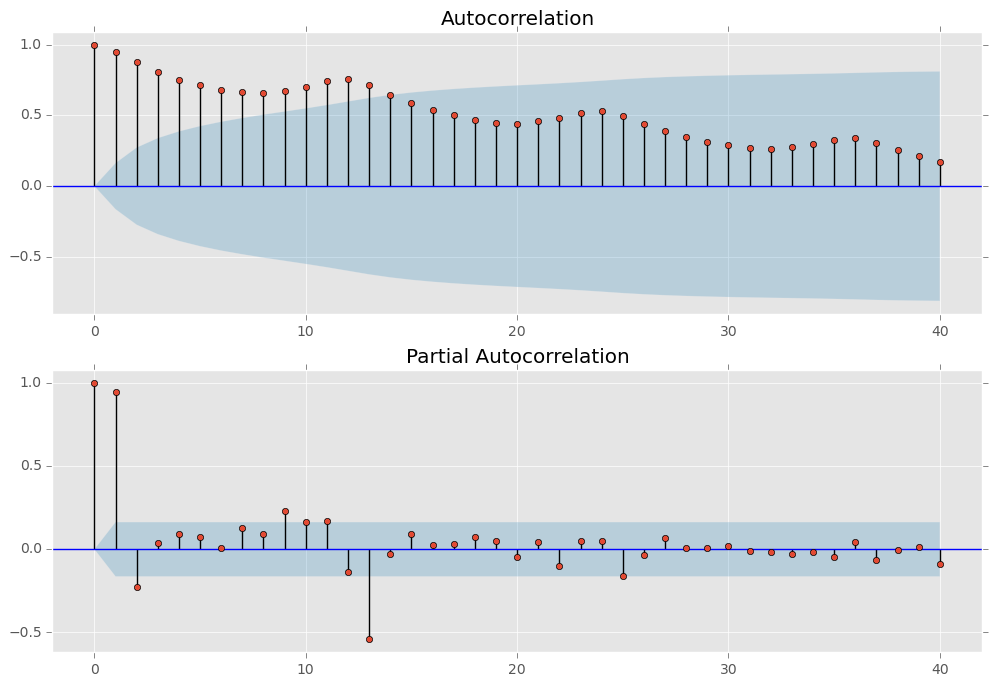

In [11]:
from statsmodels.graphics.api import qqplot

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)


Для рядов с монотонно меняющейся дисперсией можно использовать стабилизирующие преобразования, например логарифмирование.

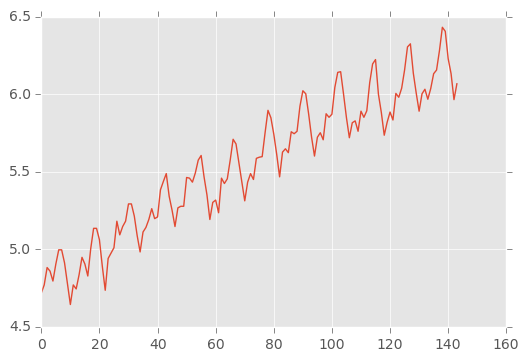

In [12]:
ts_log = np.log(ts)
plt.plot(ts_log)

**Простые методы сглаживания значений: скользящее среднее**

/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


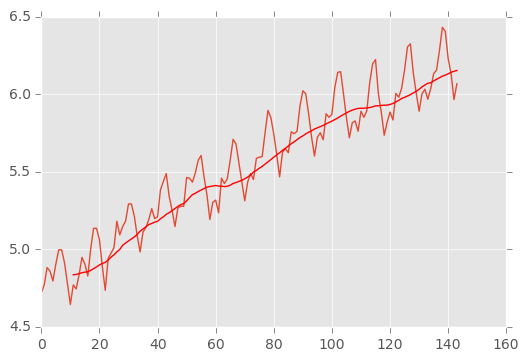

In [13]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [14]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

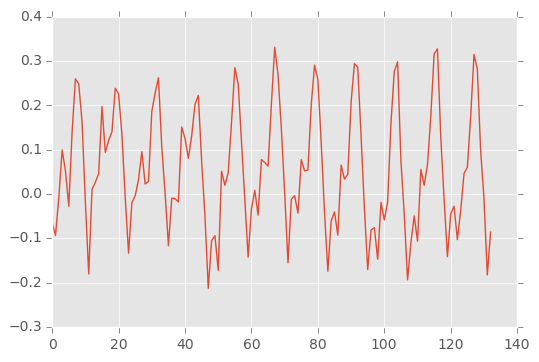

In [15]:
plt.plot(ts_log_moving_avg_diff)

**Простые методы сглаживания значений: экспоненциально взвешенное скользящее среднее**

/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


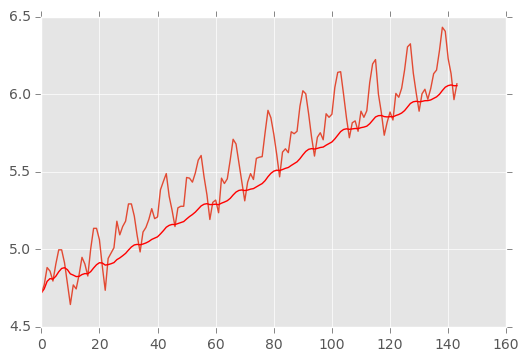

In [16]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

In [17]:
ts_log_ewma_diff = ts_log - expwighted_avg

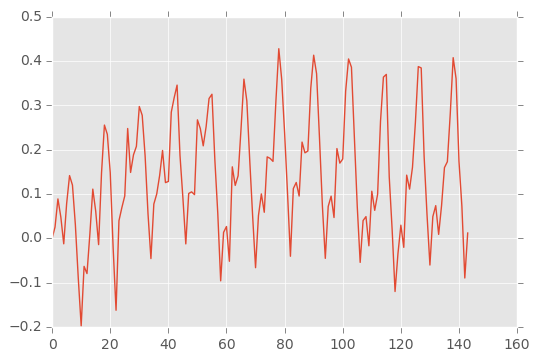

In [18]:
plt.plot(ts_log_ewma_diff)

** Методы устранения тренда: взятие первых разностей**

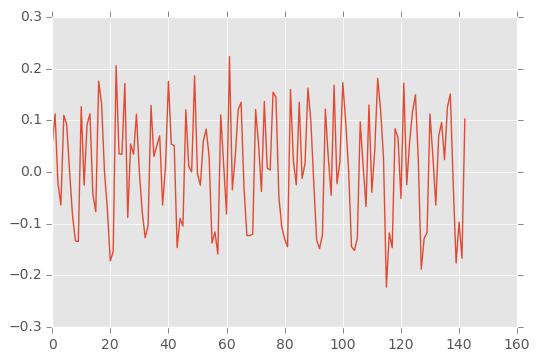

In [19]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)

### Тест Дики-Фуллера

Неформально говоря, можем определить тест Дики-Фулера следующим образом:


Допустим значение процесса в текущий момент времени зависит от значения процесса в предыдущий момент времени:
$$ y_t = \rho y_{t-1} + \epsilon_t,$$

Если перейти к математическому ожиданию, то получится, что нестационарный временной ряд соотвествуе случаю $\rho = 1$. Тест Дики-Фуллера состоит в том, чтобы взять разность ряда, а затем проверить гипотезу о единичном корне.

In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


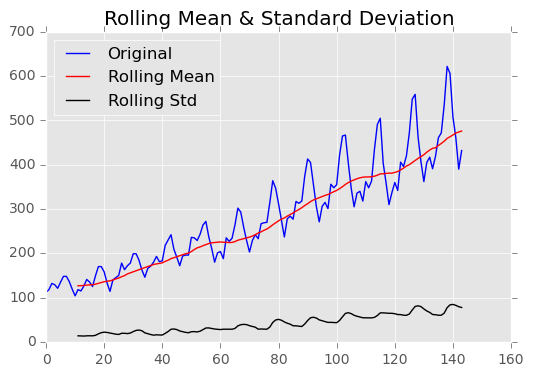

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [21]:
test_stationarity(ts)

/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


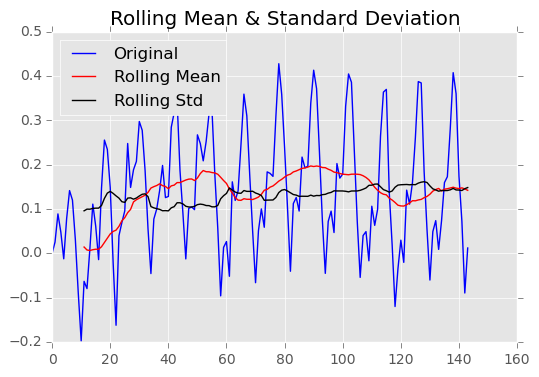

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
test_stationarity(ts_log_ewma_diff)

/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


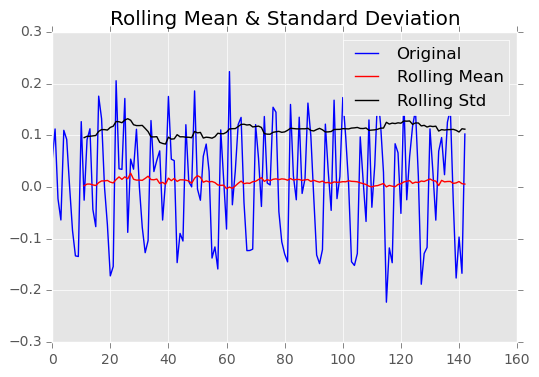

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [23]:
test_stationarity(ts_log_diff)

/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


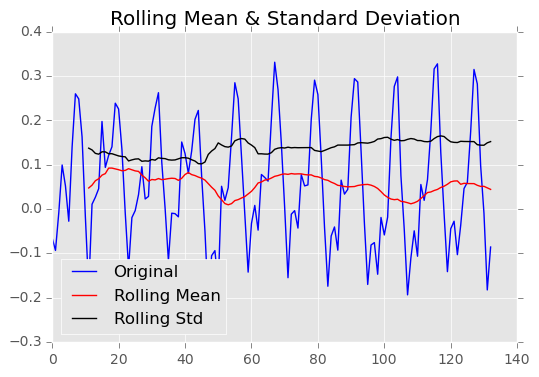

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [24]:
test_stationarity(ts_log_moving_avg_diff)

## Оценка сезонности

В statsmodels включен порт простой функции оценки сезонности из R: https://stat.ethz.ch/R-manual/R-devel/library/stats/html/decompose.html

Суть метода:
- оценить тренд с помощью скользящего среднего;
- после вычета тренда оцениваются коэффициенты сезонности;
- после вычета тренда и сезонных компонент остаемся с рядом, который должен быть стационарным.

/usr/local/lib/python2.7/dist-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


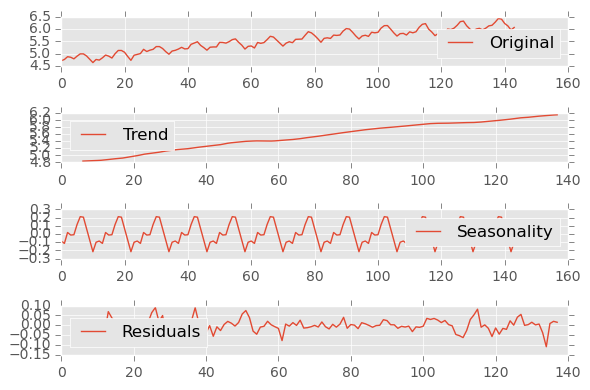

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/home/s/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


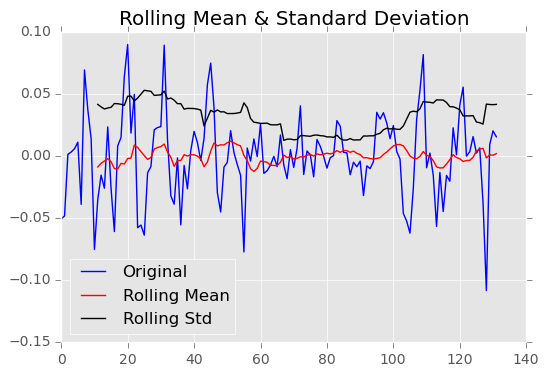

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [26]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Модель авторегресии AR

Процессом авторегрессии порядка p назовем следующий процесс:
$$ y_t = \sum_{i=1}^{p} \rho_i y_{t-i} + \epsilon_t.$$

Оценка - с помощью уравнений Юла-Уокера.

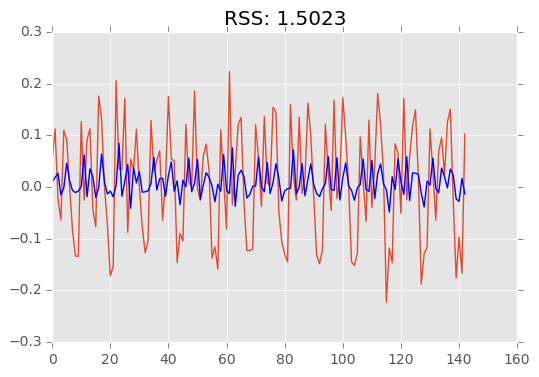

In [27]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Автокорреляционная функция процесса авторегрессии затухает с увеличением лага, частная автокорреляционная функция равна нулю для лагов больше, чем $p$.

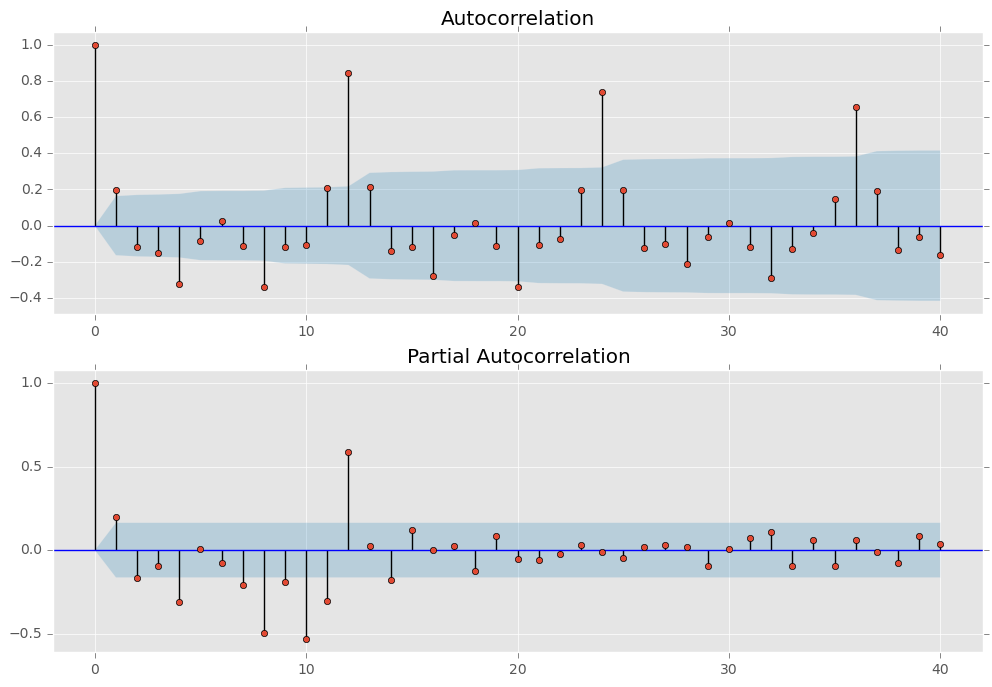

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff, lags=40, ax=ax2)

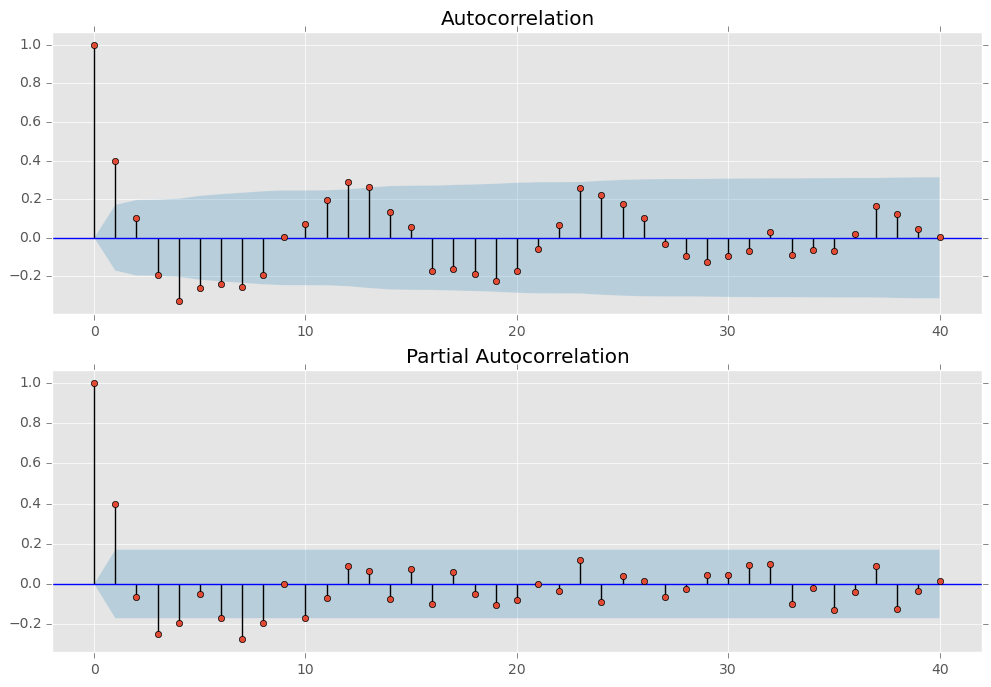

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_decompose, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_decompose, lags=40, ax=ax2)

Попробуем сгенерировать данные, порожденные таким процессом.

In [30]:
def ts_gen_ar1(size, sigma, alpha1):
    e=sigma*np.random.randn(size)
    x=np.zeros(size)
    for i in np.arange(1,size,1):
        x[i] = alpha1*x[i-1] + e[i]
    return x

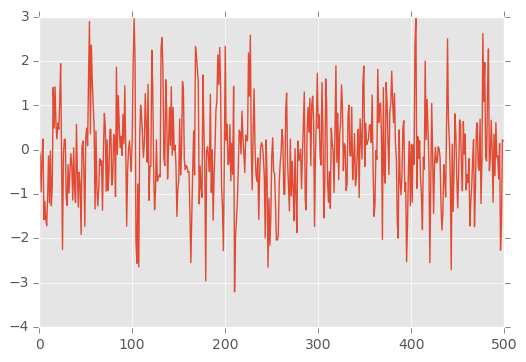

In [31]:
ts1 = ts_gen_ar1(500, 1., 0.3)
plt.plot(ts1);

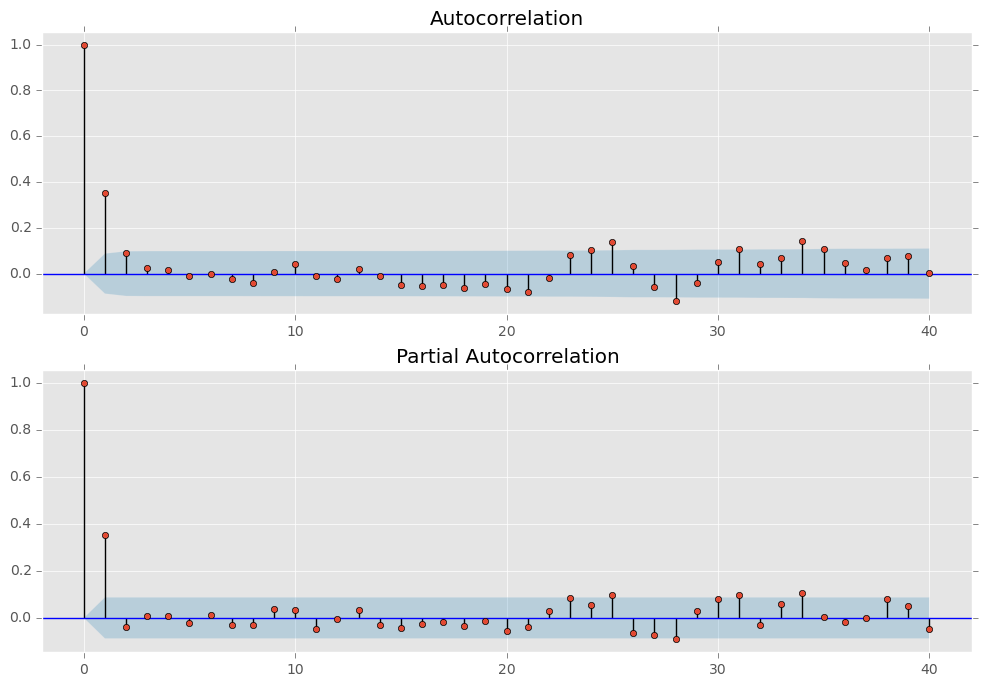

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts1, lags=40, ax=ax2)

Необходимое и достаточное условие стационарности процесса:

$$ \lvert z \rvert  > 1,$$

где $z$ - корнихарактеристического полинома:

$$ \alpha(z) = 1 - \sum_{i=1}^p \rho_i z_i.$$

Для модели AR(1) это эквивалентно требованию: $\lvert \rho \rvert <1$, для модели AR(2): $\lvert \rho_2 \rvert <1$, $\rho_1 \pm \rho_2 <1$.

### Модель скользящего среднего MA

Модель скользящего среднего основана на декомпозиции Вольда, которая представляет значение процесса в текущий момент времени t как сумму случайных "шоков" за период времени q:

$$ y_t = \epsilon_t + \sum_{i=1}^{q} b_i \epsilon_{t-i}. $$

Здесь, напротив, автокорреляционная функция после $q$ равна нулю, а частная автокорреляционная функция постепенно затухает.

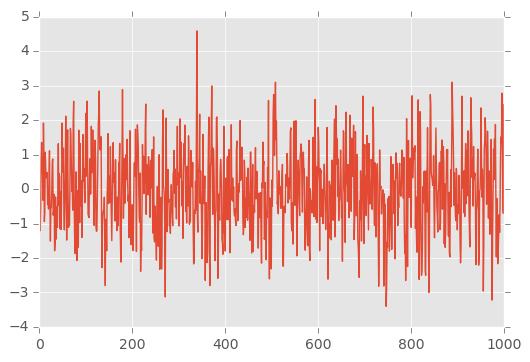

In [33]:
N=1000
ma_1=np.zeros(N)
z=np.random.randn(N)
beta1=0.5
for i in np.arange(1,N,1):
    ma_1[i] = z[i] + beta1*z[i-1]
plt.plot(ma_1)

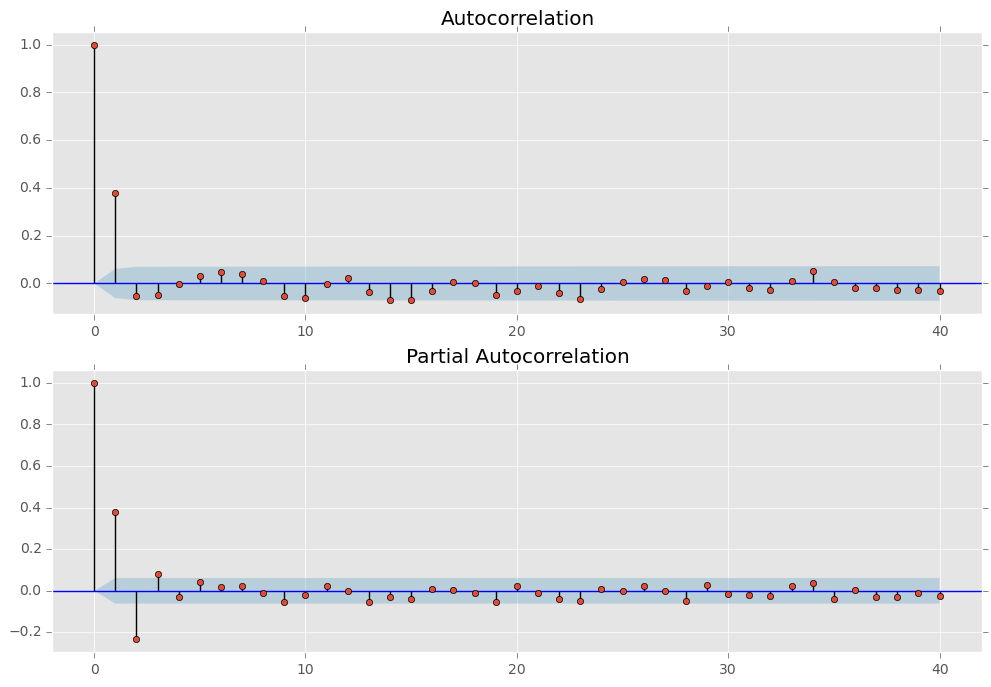

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ma_1, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ma_1, lags=40, ax=ax2)

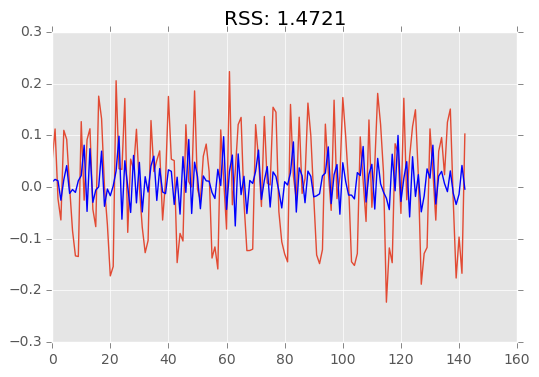

In [35]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### ARIMA = AR + MA + difference(y_t, I)

Самая известная модель - ARIMA, соединяющая воедино две предыдущие модели и параметр интеграции I, указывающий, какую степень разности ряда мы будем использовать.

Так как в данном случае мы работаем не с непостредственным временным рядом, а рядом его разностей, то модель ARIMA (p,k,q) имеет вид:

$$ \Delta^k y_t = \sum_{i=1}^{p} \rho_i \Delta^k y_{t-i} + \sum_{j=1}^{q} b_j \Delta^k y_{t-j} + \epsilon_t.$$

**Спецификация модели: процедура Бокса-Дженкинса**

- проверить гипотезу о стационарности временного ряда;
- при отвержении гипотезы привести ряд к стационарному и выбрать порядок интеграции;
- при изучении ACF и PACF выбрать порядок $p$ модели AR и порядок $q$ модели MA;
- построить модель AR/MA/ARIMA;
- проверить качество модели.

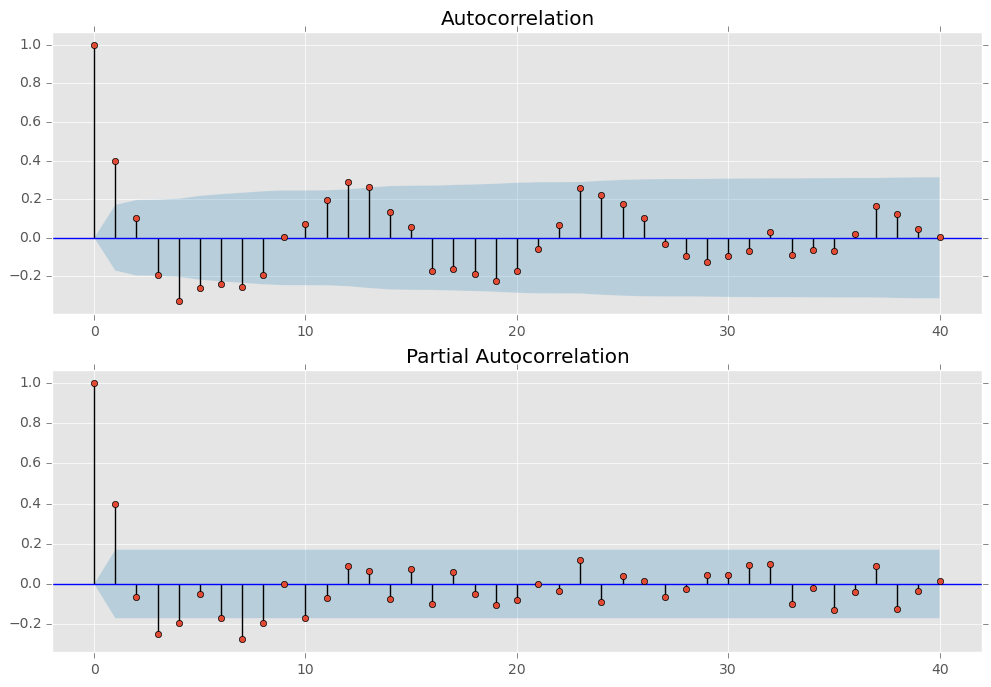

In [36]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_decompose, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_decompose, lags=40, ax=ax2)

In [37]:
model = sm.tsa.ARIMA(ts_log_decompose, order=(2,0,1))
fit = model.fit(method="mle")

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [38]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                     ARMA(2, 1)   Log Likelihood                 287.560
Method:                           mle   S.D. of innovations              0.027
Date:                Fri, 18 Nov 2016   AIC                           -565.119
Time:                        14:39:14   BIC                           -550.705
Sample:                    07-01-1949   HQIC                          -559.262
                         - 06-01-1960                                         
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                 0.0001      0.000      0.593      0.554        -0.000     0.001
ar.L1.#Passengers     1.2681      0.074     17.225      0.000         1.124     1.412
ar.L2.#Passengers    -0.5372      0.074     -7.268      0.000        -0.682    -0.392
ma.L1.#Passengers    -0.9999      0.021    -48.117      0.000        -1.041    -0.959
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1804           -0.6844j            1.3644           -0.0836
AR.2            1.1804           +0.6844j            1.3644            0.0836
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [39]:
fit.pvalues

const                5.541547e-01
ar.L1.#Passengers    3.867016e-35
ar.L2.#Passengers    3.185704e-11
ma.L1.#Passengers    7.776891e-84
dtype: float64

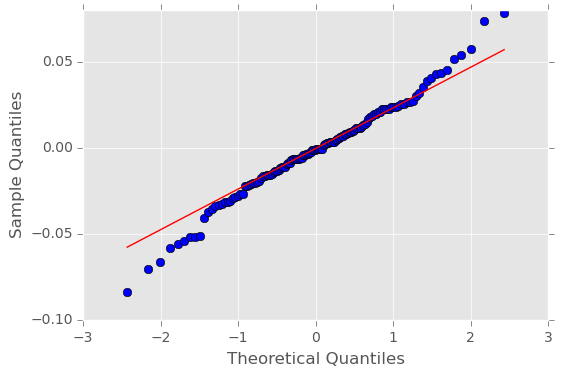

In [40]:
qqplot(fit.resid, line='q');

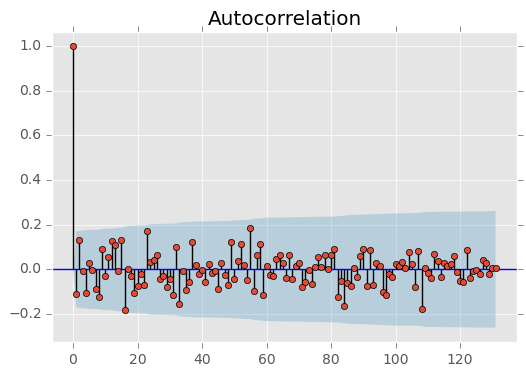

In [41]:
sm.graphics.tsa.plot_acf(fit.resid);

/usr/local/lib/python2.7/dist-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


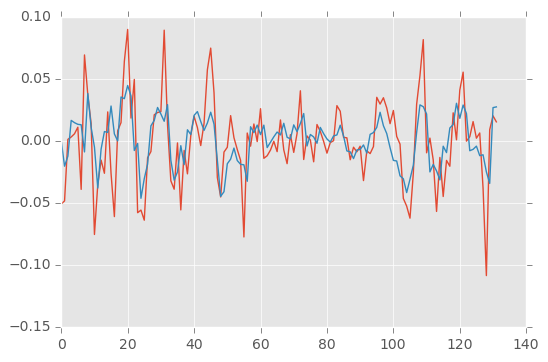

In [42]:
insample_predict=fit.predict()
plt.plot(ts_log_decompose)
plt.plot(insample_predict)

Еще один пример:

In [43]:
df=pd.read_csv("AUSCPIALLQINMEI.csv")

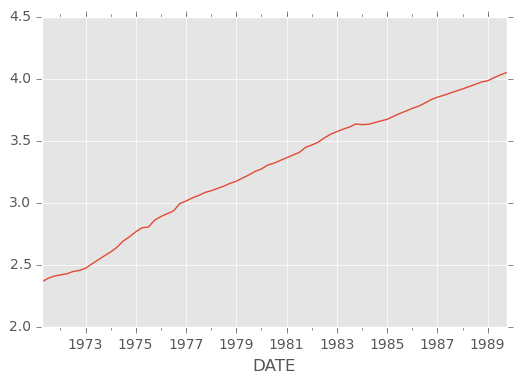

In [44]:
df.DATE = pd.to_datetime(df.DATE)
dfsub=df[(df.DATE> '1971') & (df.DATE < '1990')]
dfsub=dfsub.set_index('DATE')
cpi=dfsub.VALUE
lcpi=np.log(cpi)
lcpi.plot()

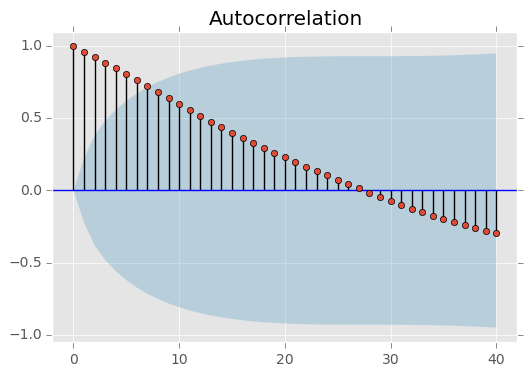

In [45]:
sm.graphics.tsa.plot_acf(lcpi, lags=40);

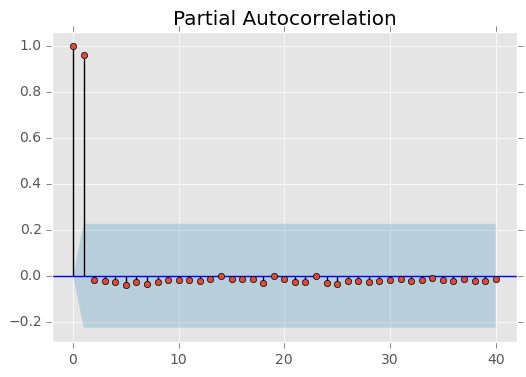

In [46]:
sm.graphics.tsa.plot_pacf(lcpi, lags=40);

In [47]:
model = sm.tsa.ARIMA(lcpi, order=(2,1,0))
fit = model.fit(method="mle")

In [48]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.VALUE   No. Observations:                   74
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 237.099
Method:                           mle   S.D. of innovations              0.010
Date:                Fri, 18 Nov 2016   AIC                           -466.199
Time:                        14:39:29   BIC                           -456.983
Sample:                    07-01-1971   HQIC                          -462.522
                         - 10-01-1989                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.0228      0.002     11.601      0.000         0.019     0.027
ar.L1.D.VALUE     0.2206      0.113      1.953      0.055        -0.001     0.442
ar.L2.D.VALUE     0.2079      0.113      1.846      0.069        -0.013     0.429
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7258           +0.0000j            1.7258            0.0000
AR.2           -2.7866           +0.0000j            2.7866            0.5000
-----------------------------------------------------------------------------
"""

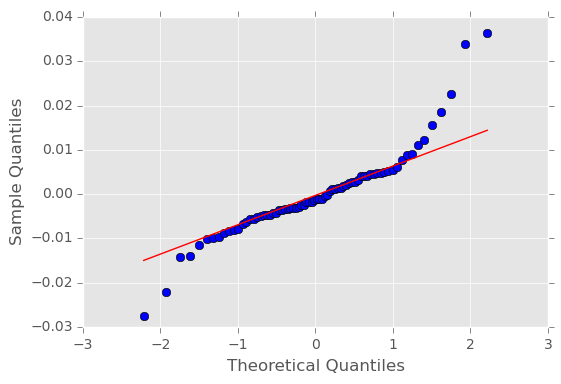

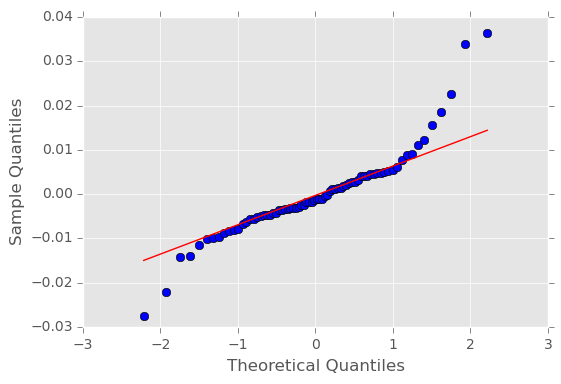

In [49]:
qqplot(fit.resid, line='q')

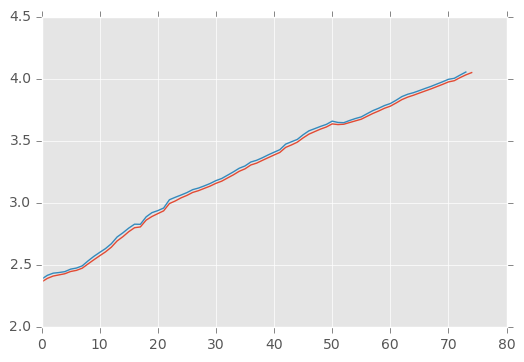

In [50]:
insample_predict=fit.predict(typ='levels')
plt.plot(lcpi)
plt.plot(insample_predict)

Сделаем прогноз на будущее:

In [51]:
start=lcpi.index.get_loc(datetime(1989,10,1))
end = start + 48
print start, end

74 122


In [52]:
ospredict=fit.predict(start=start, end=end, typ='levels')

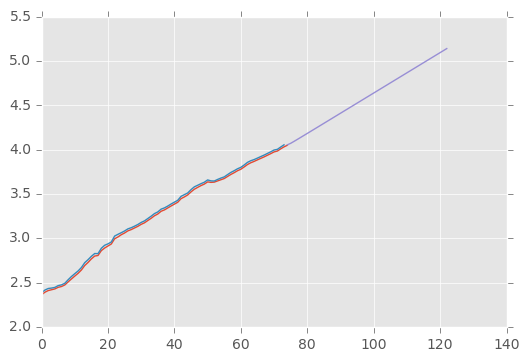

In [53]:
plt.plot(lcpi)
plt.plot(insample_predict)
plt.plot(np.arange(start,end+1,1), ospredict);

In [54]:
ospredict

1989-10-01    4.055602
1990-01-01    4.072470
1990-04-01    4.094101
1990-07-01    4.116428
1990-10-01    4.138888
1991-01-01    4.161523
1991-04-01    4.184224
1991-07-01    4.206975
1991-10-01    4.229752
1992-01-01    4.252544
1992-04-01    4.275346
1992-07-01    4.298152
1992-10-01    4.320962
1993-01-01    4.343773
1993-04-01    4.366586
1993-07-01    4.389399
1993-10-01    4.412212
1994-01-01    4.435025
1994-04-01    4.457839
1994-07-01    4.480653
1994-10-01    4.503466
1995-01-01    4.526280
1995-04-01    4.549094
1995-07-01    4.571907
1995-10-01    4.594721
1996-01-01    4.617535
1996-04-01    4.640349
1996-07-01    4.663162
1996-10-01    4.685976
1997-01-01    4.708790
1997-04-01    4.731603
1997-07-01    4.754417
1997-10-01    4.777231
1998-01-01    4.800045
1998-04-01    4.822858
1998-07-01    4.845672
1998-10-01    4.868486
1999-01-01    4.891300
1999-04-01    4.914113
1999-07-01    4.936927
1999-10-01    4.959741
2000-01-01    4.982555
2000-04-01    5.005368
2000-07-01 